In [4]:
from torchsummary import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
from tabulate import tabulate
import time
import random
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["PYTHONWARNINGS"] = "ignore"


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
dir_ = '../Rice_Image_Dataset/'
os.listdir(dir_)

['Arborio',
 'Basmati',
 'Ipsala',
 'Jasmine',
 'Karacadag',
 'Rice_Citation_Request.txt',
 'Rice_classification.ipynb']

In [25]:
Classes = os.listdir(dir_) # So with this code we can store the name of classes
Classes.remove('Rice_Citation_Request.txt') # Removing the redundant file
Classes.remove('Rice_classification.ipynb') # Removing the redundant file
Classes

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

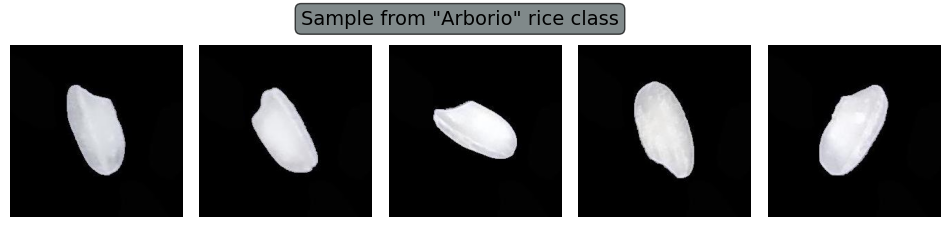

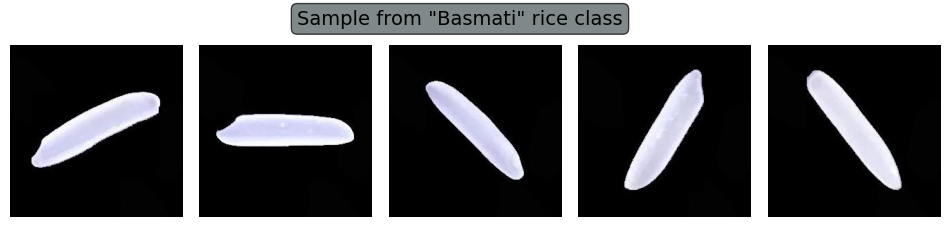

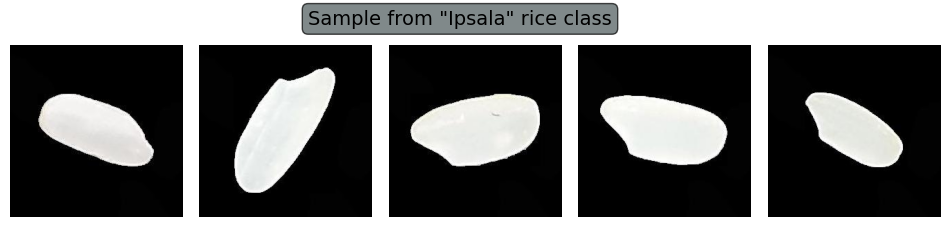

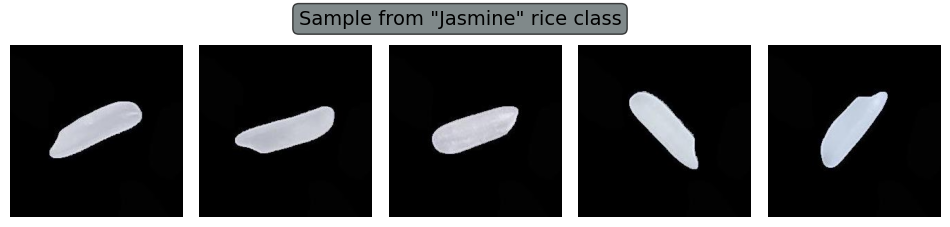

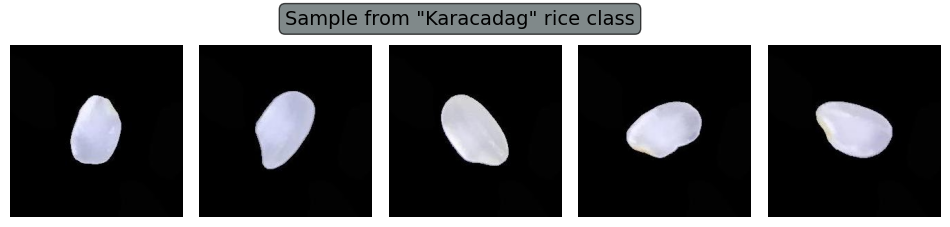

In [26]:
# Plotting random images of each file(class)

for rice_class in Classes : # Loop through each class
    
    # Accessing images in files 
    class_dir = os.path.join(dir_ , rice_class) # The image path of the rice class
    images_path = os.listdir(class_dir) # List of images
    random_images = random.sample(images_path , k = 5) # Random sample of images
    
    # Plotting some sample images
    fig , ax = plt.subplots(1 , 5 , figsize = (12 , 3)) 
    plt.suptitle(f'Sample from "{rice_class}" rice class', fontsize = 14 
                 , bbox=dict(facecolor='#4A5759', alpha=0.7 , boxstyle='round,pad=0.3') , y = 0.9) # Title for each sample
    
    for i , random_image in enumerate(random_images) : # Loop for each image
        image_path = os.path.join(class_dir , random_image) # Creating image path
        image = Image.open(image_path) # Load image
        
        ax[i].imshow(image) # Plot image
        ax[i].axis('off') # Remove the axis
    
    plt.subplots_adjust( hspace = -0.2 , wspace = 0.1 )
    plt.show()
    print('\n')

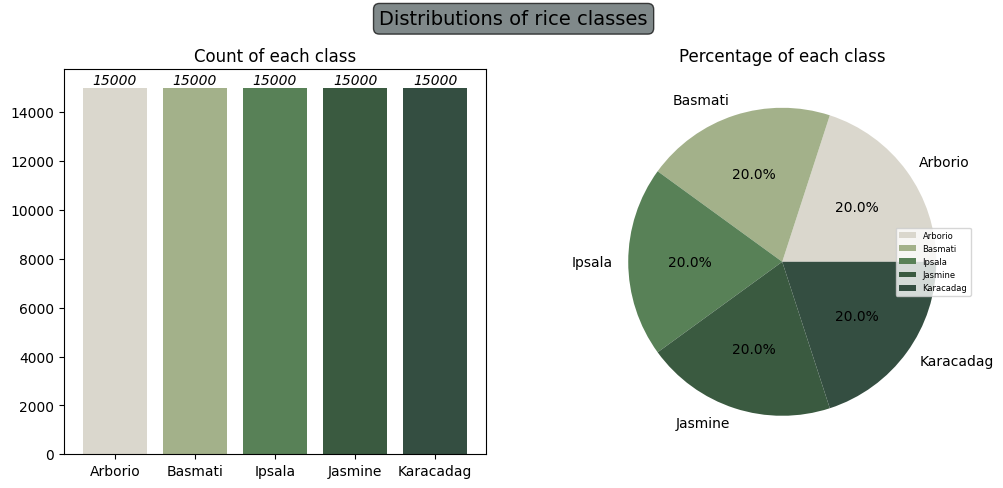

In [27]:
class_count = [] # Storing the amount of data in each class

for rice_class in Classes :
    image_dir = os.path.join(dir_ , rice_class)
    image_path = os.listdir(image_dir)
    count = len(image_path) # Amount of data in each class
    class_count.append(count)
    
    
color=['#dad7cd' , '#a3b18a','#588157' , '#3a5a40' , '#344e41' ]
fig , ax = plt.subplots(1 , 2 , figsize = (12 , 5))
plt.suptitle(f'Distributions of rice classes' , fontsize = 14 
                 , bbox=dict(facecolor='#4A5759', alpha=0.7 , boxstyle='round,pad=0.3') , y = 1)

# Bar Plot
ax[0].set_title("Count of each class")
ax[0].bar(Classes , class_count , color = color) # Creating a bar plot
for i , v in enumerate(class_count):
        ax[0].text(i , v , str(v) , ha='center', va='bottom', fontstyle = "oblique" , fontsize=10) # Putting each bar number on the top

# Pie plot for percentage        
ax[1].set_title('Percentage of each class')
ax[1].pie(class_count,
    labels = Classes , autopct='%1.1f%%' , colors = color)
ax[1].legend(fontsize = 6 , loc = 'center right')

plt.show()

In [28]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224 , 224)) , # Resize images to 224x224
    transforms.ToTensor() , # Convert images to PyTorch tensors
    transforms.Normalize( mean = 0 , std = 1) # Normalizing Images
])

In [30]:
# Load the entire dataset from a folder
dataset = datasets.ImageFolder(root = dir_ , transform = transform) 
dataset

Dataset ImageFolder
    Number of datapoints: 75000
    Root location: ../Rice_Image_Dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0, std=1)
           )

In [31]:
# Calculating the number of our data points
num_data = len(dataset)

# Set the lengths of the train, validation, and test sets
train_size = int(0.7 * num_data)  # 70% for training
val_size = int(0.15 * num_data)   # 15% for validation
test_size = num_data - (train_size + val_size)  # Remaining 15% for testing

In [32]:
# Split the dataset into train, validation, and test sets
train_dataset , val_dataset , test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [33]:
# Create DataLoaders for each subset
train = DataLoader(train_dataset , batch_size = 32 , shuffle = True , num_workers = 2)
val = DataLoader(val_dataset , batch_size = 32 , shuffle = True , num_workers = 2)
test = DataLoader(test_dataset , batch_size = 32 , shuffle = True , num_workers = 2)

In [34]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [35]:
class CNN(nn.Module) :
    
    def __init__(self) :
        
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            
            # First conv layer
            nn.Conv2d(in_channels = 3 , out_channels = 32 , kernel_size = (3,3) , stride = 1), # 64 conv filter
            nn.BatchNorm2d(32), # Normalize the outputs of the previous layer
            nn.ReLU(), # Apply ReLU activation
            nn.MaxPool2d(kernel_size = (2,2) , stride = 2), # Reduce spatial dimensions by half
            
            
            # ُSecond conv layer
            nn.Conv2d(in_channels = 32 , out_channels = 64 , kernel_size = (3,3) , stride = 1), # 64 conv filter
            nn.BatchNorm2d(64), # Normalize the outputs of the previous layer
            nn.ReLU(), # Apply ReLU activation
            nn.BatchNorm2d(64), # Normalize the outputs of the previous layer
            nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = (3,3) , stride = 1), # 64 conv filter
            nn.ReLU(), # Apply ReLU activation
            nn.MaxPool2d(kernel_size = (2,2) , stride = 2), # Reduce spatial dimensions by half
            
            
            # Third conv layer
            nn.Conv2d(in_channels = 64 , out_channels = 128 , kernel_size = (3,3) , stride = 1), # 128 conv filter
            nn.BatchNorm2d(128), # Normalize the outputs of the previous layer
            nn.ReLU(), # Apply ReLU activation
            nn.Conv2d(in_channels = 128 , out_channels = 128 , kernel_size = (3,3) , stride = 1), # 128 conv filter
            nn.BatchNorm2d(128), # Normalize the outputs of the previous layer
            nn.ReLU(), # Apply ReLU activation
            nn.MaxPool2d(kernel_size = (2,2) , stride = 2) # Reduce spatial dimensions by half
            
        )
        
        self.fully_connected = nn.Sequential(
            
            # Fully conected layer
            nn.Linear(73728 , 512), # Fully connected layer with 512 node
            nn.ReLU(),
            nn.Dropout(0.3), # Dropout layer for regularization
            nn.Linear(512 , 5) # Final layer: From 512 units to the number of classes
        )
        
    def forward(self , X) :
            
        out = self.conv_layers(X)
        out = torch.flatten(out , 1)
        out = self.fully_connected(out)
        return out # Return the final output (logits or class scores)
            
model = CNN()
model.to(device) # Move the model to the specified device
model

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

In [38]:
summary(model, (3, 224, 224)) # To get a summary of our model

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 24, 24]         --
|    └─Conv2d: 2-1                       [-1, 32, 222, 222]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 222, 222]        64
|    └─ReLU: 2-3                         [-1, 32, 222, 222]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 111, 111]        --
|    └─Conv2d: 2-5                       [-1, 64, 109, 109]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 109, 109]        128
|    └─ReLU: 2-7                         [-1, 64, 109, 109]        --
|    └─BatchNorm2d: 2-8                  [-1, 64, 109, 109]        128
|    └─Conv2d: 2-9                       [-1, 64, 107, 107]        36,928
|    └─ReLU: 2-10                        [-1, 64, 107, 107]        --
|    └─MaxPool2d: 2-11                   [-1, 64, 53, 53]          --
|    └─Conv2d: 2-12                      [-1, 128, 51, 51]         73,856


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 24, 24]         --
|    └─Conv2d: 2-1                       [-1, 32, 222, 222]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 222, 222]        64
|    └─ReLU: 2-3                         [-1, 32, 222, 222]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 111, 111]        --
|    └─Conv2d: 2-5                       [-1, 64, 109, 109]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 109, 109]        128
|    └─ReLU: 2-7                         [-1, 64, 109, 109]        --
|    └─BatchNorm2d: 2-8                  [-1, 64, 109, 109]        128
|    └─Conv2d: 2-9                       [-1, 64, 107, 107]        36,928
|    └─ReLU: 2-10                        [-1, 64, 107, 107]        --
|    └─MaxPool2d: 2-11                   [-1, 64, 53, 53]          --
|    └─Conv2d: 2-12                      [-1, 128, 51, 51]         73,856


In [40]:
class EarlyStop :
    
    def __init__(self , patience , min_delta , start_from_epoch) :
        self.patience = patience
        self.min_delta = min_delta
        self.start_from_epoch = start_from_epoch
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        
    def __call__(self , val_loss , epoch) :
        
        if self.start_from_epoch <= epoch :
    
            if self.best_val_loss == None :
                self.best_val_loss = val_loss
                
            elif (val_loss<self.best_val_loss) and ((self.best_val_loss-val_loss > self.min_delta )) :
                self.best_val_loss = val_loss
                self.counter = 0
                
            elif val_loss>=self.best_val_loss :
                self.counter += 1
                
                if self.counter == self.patience :
                    self.early_stop = True
                    

In [41]:
# Define Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# A scheduler to reduce learning rate when there is no improvement
Scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer ,
    factor = 0.5 , 
    patience = 2 , 
    threshold = 0.001,
    min_lr = 1e-5)

# A callback to stop training after 5 epoch without any improvement
early_stopping = EarlyStop(
    min_delta = 0.001 , # Minimum change in the monitored quantity to qualify as an improvement
    patience = 5 , # Number of epochs with no improvement after which training will be stopped
    start_from_epoch = 5) # Number of epochs to wait before starting to monitor improvement

# Number of epochs for training
num_epochs = 20

# Initialize arrays to store loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = float('inf') # Starter point for finding the best model to save
learning_rate = []

training_start_time = time.time() # Beginning of training
# A loop for each epoch
for epoch in range(num_epochs) :
    
    print(f'Epoch [{epoch+1}/{num_epochs}]\n-------------------------------')
    
    # Reset the accuracy and loss of epoch
    train_loss = []
    val_loss = []
    corrected_train = 0
    corrected_val = 0
    
    # Set model to train mode
    model.train()
    
    epoch_start_time = time.time() # Beginning of epoch

    # A loop through batches
    for batch , (X , y) in enumerate(train) :
        
        # Move X and y to the device (GPU)
        X = X.to(device)
        y = y.to(device)
        
        # Compute predicted labels and loss
        train_batch_pred = model(X)
        loss = loss_fn(train_batch_pred , y)
        
        # Backward pass: Compute gradients
        loss.backward() 
        optimizer.step()
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Store loss and the number of corectly predicted samples
        train_loss.append(loss.item())
        _ , pred_label = torch.max(train_batch_pred , 1)
        corrected_train += (pred_label == y).sum().item()
        
        if batch % 200 == 0:

            print(f"loss: {np.mean(train_loss):>7f}  [{batch:>3d}/{len(train):>3d}]")
    
    # Update the list of accuracy and losses
    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)
    train_accs.append((corrected_train/train_size)*100)
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad(): # No need to track gradients during validation

        # A loop through each batch of validation dataset
        for X , y in val :
            
            # Move X and y to the device (GPU)
            X = X.to(device)
            y = y.to(device)
            
            # Compute predicted labels and loss
            val_batch_pred = model(X)
            loss = loss_fn(val_batch_pred , y)
            
            # Store loss and the number of corectly predicted samples
            val_loss.append(loss.item())
            _ , pred_label = torch.max(val_batch_pred , 1)
            corrected_val += (pred_label == y).sum().item()
            
    # Update the list of accuracy and losses        
    val_loss = np.mean(val_loss)
    val_losses.append(val_loss)
    val_accs.append((corrected_val/val_size)*100)
    
    # Print current learning rate
    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")
        learning_rate.append(param_group['lr'])

    # Call scheduler.step with validation loss
    Scheduler.step(val_loss)
    
    # Saving the best model
    if val_loss<best_val_loss :
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        print("Best model weights saved.")
        
    epoch_end_time = time.time() # End of epoch
    epoch_time = epoch_end_time - epoch_start_time
        
    # Print the metrics for the current epoch
    print(f'Errors : \n'
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accs[epoch]:.4f} | '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accs[epoch]:.4f} | '
          f'Duration: {(epoch_time//60)} minutes and {(epoch_time%60):.2f} seconds')
    print('\n'*2)
    
    # Decide if we should stop in this epoch
    early_stopping(val_loss , epoch)
    if early_stopping.early_stop :
        print("Early stopping triggered!")
        break
        
training_end_time = time.time() # End of training
duration = training_end_time - training_start_time # Training time
print(f"\nTotal training time : {(duration//60)} minutes and {(duration%60):.2f} seconds")

torch.save(best_model_wts, "rice_classification_model.pth")

Epoch [1/20]
-------------------------------
loss: 1.718905  [  0/1641]
loss: 1.371408  [200/1641]
loss: 0.774908  [400/1641]
loss: 0.560878  [600/1641]
loss: 0.441366  [800/1641]
loss: 0.369699  [1000/1641]
loss: 0.329081  [1200/1641]
loss: 0.296402  [1400/1641]
loss: 0.269096  [1600/1641]
Current learning rate: 0.001
Best model weights saved.
Errors : 
Train Loss: 0.2641, Train Accuracy: 94.6762 | Val Loss: 0.1289, Val Accuracy: 96.2222 | Duration: 4.0 minutes and 51.56 seconds



Epoch [2/20]
-------------------------------
loss: 0.009596  [  0/1641]
loss: 0.072830  [200/1641]
loss: 0.074552  [400/1641]
loss: 0.075526  [600/1641]
loss: 0.072277  [800/1641]
loss: 0.071658  [1000/1641]
loss: 0.070545  [1200/1641]
loss: 0.071568  [1400/1641]
loss: 0.078612  [1600/1641]
Current learning rate: 0.001
Best model weights saved.
Errors : 
Train Loss: 0.0795, Train Accuracy: 97.7010 | Val Loss: 0.1287, Val Accuracy: 96.5067 | Duration: 2.0 minutes and 15.58 seconds



Epoch [3/20]
-----------

In [42]:
# Loading Best Model
model.load_state_dict(torch.load("rice_classification_model.pth"))

# Create a dictionary to store the training and validation metrics
history = {
    'Train_Loss': train_losses,
    'Val_Loss': val_losses,
    'Train_Accuracy': train_accs,
    'Val_Accuracy': val_accs,
    'Learning Rate': learning_rate}

In [43]:
# Convert result of training to a df
model_performance = pd.DataFrame(history)
print(tabulate(model_performance, headers='keys', tablefmt='psql'))

+----+--------------+------------+------------------+----------------+-----------------+
|    |   Train_Loss |   Val_Loss |   Train_Accuracy |   Val_Accuracy |   Learning Rate |
|----+--------------+------------+------------------+----------------+-----------------|
|  0 |   0.264098   | 0.128868   |          94.6762 |        96.2222 |          0.001  |
|  1 |   0.0794794  | 0.128653   |          97.701  |        96.5067 |          0.001  |
|  2 |   0.0494915  | 0.286489   |          98.5524 |        89.5911 |          0.001  |
|  3 |   0.0441259  | 0.257989   |          98.6629 |        91.3511 |          0.001  |
|  4 |   0.0347666  | 0.0337879  |          98.9886 |        98.9778 |          0.001  |
|  5 |   0.0253256  | 0.014649   |          99.2514 |        99.6444 |          0.001  |
|  6 |   0.0178311  | 0.00881456 |          99.4857 |        99.7511 |          0.001  |
|  7 |   0.0159714  | 0.0114292  |          99.5467 |        99.68   |          0.001  |
|  8 |   0.0131754  |

In [44]:
test_pred_label = [] # Prediction lables
true_labels = [] # True labels

with torch.no_grad(): # No need to track gradients during validation
    
    model.eval() # Set the model to evaluation mode
    test_loss = []
    corrected_test = 0

    # A loop through each batch of dataset
    for X , y in test :

        # Move X and y to the device (GPU)
        X = X.to(device)
        y = y.to(device)

        # Compute predicted labels and loss
        test_batch_pred = model(X)
        loss = loss_fn(test_batch_pred , y)

        # Store loss and the number of corectly predicted samples
        test_loss.append(loss.item())
        _ , pred_label = torch.max(test_batch_pred , 1)
        corrected_test += (pred_label == y).sum().item()
        
        test_pred_label.extend(pred_label.cpu().numpy())
        true_labels.extend(y.cpu().numpy())
        
        
    test_pred_label = np.array(test_pred_label)
    true_labels = np.array(true_labels)
    
    
    
    test_loss = np.mean(val_loss)
    test_acc = (corrected_test/test_size)*100
    
    # Display the evaluation results with clear and formatted output
    print("\nModel Evaluation Results:")
    print(f'Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc}%')

    


Model Evaluation Results:
Loss: 0.0099
Accuracy: 99.85777777777778%


In [45]:
# A loop through one batch of dataset
for X , y in test :

    # Move X and y to the device (GPU)
    X = X.to(device)
    y = y.to(device)
    break
# Compute predicted labels
test_batch_pred = model(X)
_ , pred_label = torch.max(test_batch_pred , 1)

output = torch.softmax(test_batch_pred, dim=1).squeeze()
prob , _ = torch.max(output , 1)

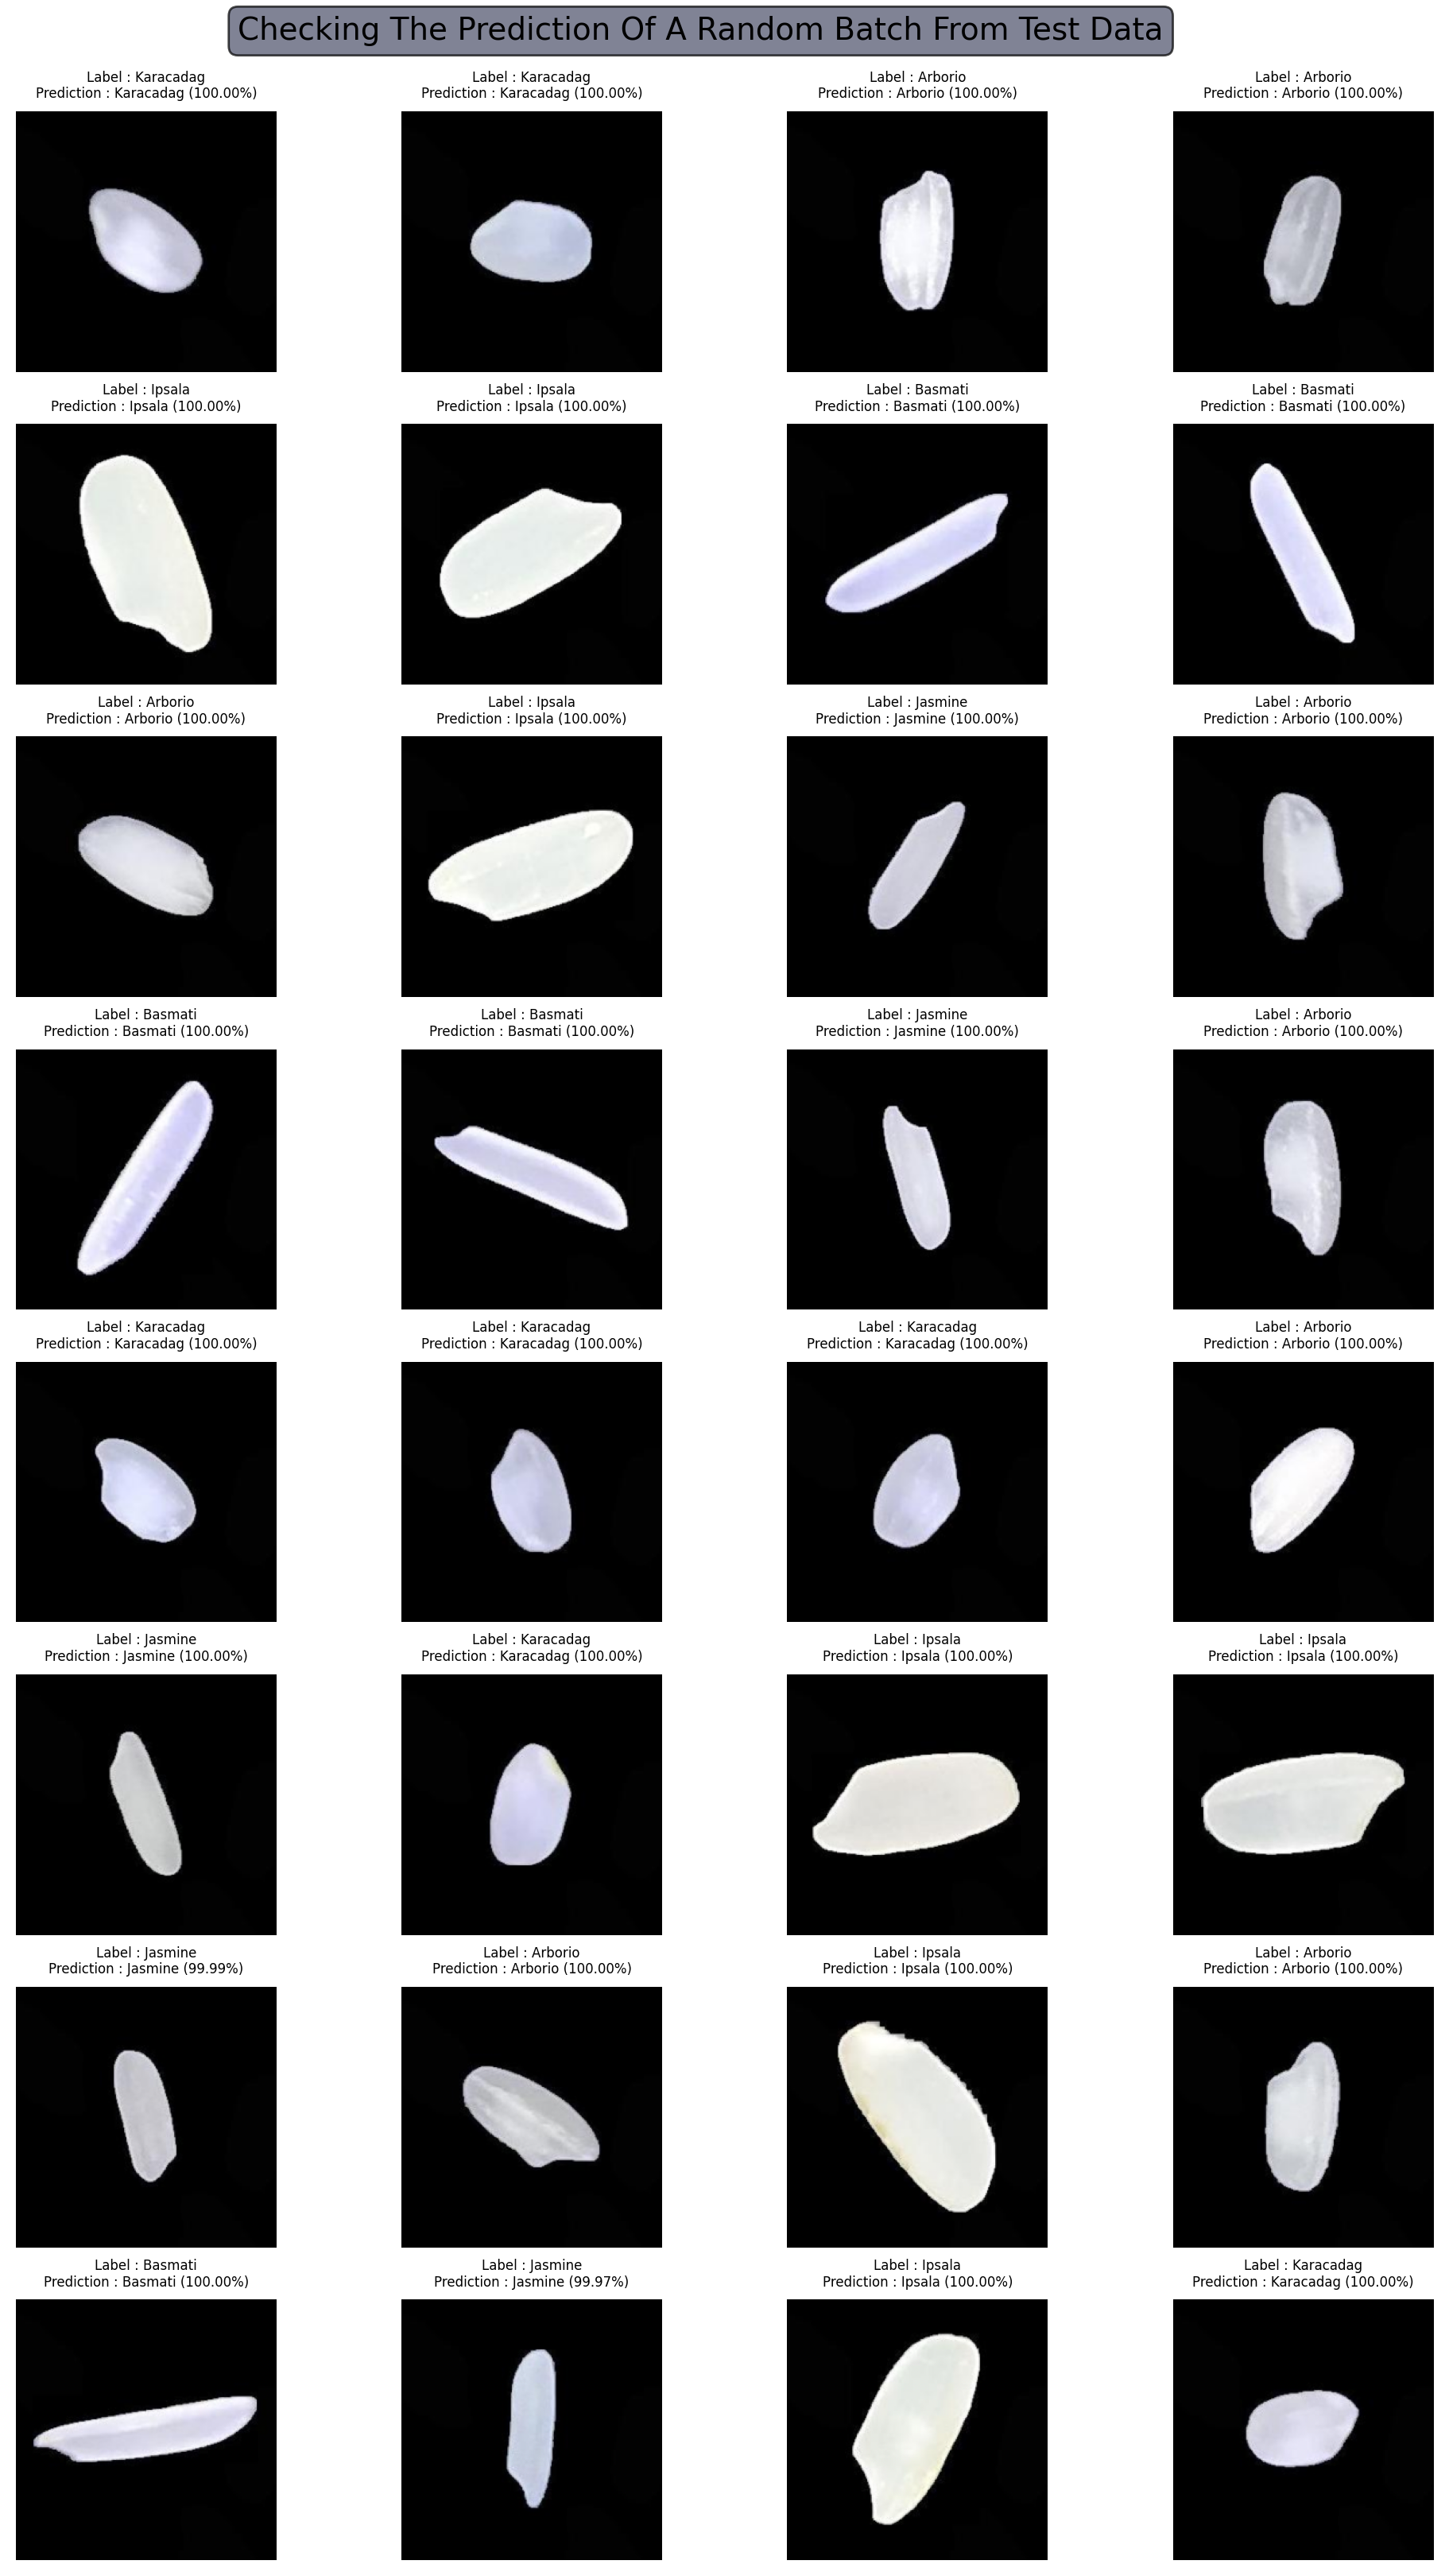

In [46]:
# Plotting the batch

fig , ax = plt.subplots(8,4 , figsize = (12 , 20) , dpi=200)
ax = ax.flatten() # Flatten ax so we could iterate through it
plt.suptitle(f'Checking The Prediction Of A Random Batch From Test Data', fontsize = 14 
                 , bbox=dict(facecolor='#4a4e69', alpha=0.7 , boxstyle='round,pad=0.3') , y = 0.91)

for n , i in enumerate(ax) : 

    img = X[n].permute(1, 2, 0).cpu().numpy()
    i.imshow(img) # Plotting the image
    i.axis('off') # Remove the axis
    i.set_title(f"Label : {Classes[y[n]]}\n"
                f"Prediction : {Classes[pred_label[n]]} ({100*(prob[n].item()):.2f}%)" ,
                fontsize = 6) # Setting true and predicted label as the title
plt.show()